In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import skimage.io

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from src.utils import down_sample, load_images, orthogonal_init
from src.cnn import MyUNet

## Load data

In [2]:
# Load ground truths.
ims_gt = load_images()
ims_gt.shape

(15, 1024, 1024, 3)

In [3]:
# Load in torch (model requires batch x channels x height x width)
gt_data = torch.tensor(ims_gt.transpose((0,3,1,2)))
ds_data = torch.cat([down_sample(im, stride=12)[None,:] for im in gt_data])
print(gt_data.shape, ds_data.shape)

torch.Size([15, 3, 1024, 1024]) torch.Size([15, 3, 1024, 1024])


In [4]:
Xtrain = ds_data[0:10]
ytrain = gt_data[0:10]
Xtest = ds_data[10:15]
ytest = ds_data[10:15]

## Test own unet

## Load model

In [6]:
# unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=3, init_features=10, pretrained=False)
unet = MyUNet()

## Setup GPU

In [7]:
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda:1')
unet.to(device);

## Train 

In [8]:
n_epochs = 100

mse_loss = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
train_loss = []
test_loss = []

for epoch in range(n_epochs):
    # Training
    unet.train()
    batch_loss = []
    for X, y in zip(Xtrain, ytrain):
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred = unet(X[None, :])
        loss = mse_loss(pred, y[None, :])
        batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    
    train_loss.append(np.mean(batch_loss))
    
    # Validation
    unet.eval()
    with torch.no_grad():
        batch_loss = []
        for X, y in zip(Xtest, ytest):
            X = X.to(device)
            y = y.to(device)
            pred = unet(X[None, :])
            loss = mse_loss(pred, y[None, :])
            batch_loss.append(loss.item())

        test_loss.append(np.mean(batch_loss))

    if epoch % 10 == 0:
        print(f"epoch: {epoch} \t train loss: {train_loss[-1]:.6f} \t test loss {test_loss[-1]:.6f}")
    
    

epoch: 0 	 train loss: 0.570984 	 test loss 0.262948
epoch: 10 	 train loss: 0.001964 	 test loss 0.197410
epoch: 20 	 train loss: 0.000971 	 test loss 0.194108
epoch: 30 	 train loss: 0.000495 	 test loss 0.193140
epoch: 40 	 train loss: 0.000375 	 test loss 0.193185
epoch: 50 	 train loss: 0.000374 	 test loss 0.199096
epoch: 60 	 train loss: 0.000505 	 test loss 0.187254
epoch: 70 	 train loss: 0.000258 	 test loss 0.193117
epoch: 80 	 train loss: 0.000171 	 test loss 0.192859
epoch: 90 	 train loss: 0.000156 	 test loss 0.193455


## Results

In [9]:
unet.eval();
idx = 14
with torch.no_grad():
    X = ds_data[None, idx].to(device)
    pred = unet(X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


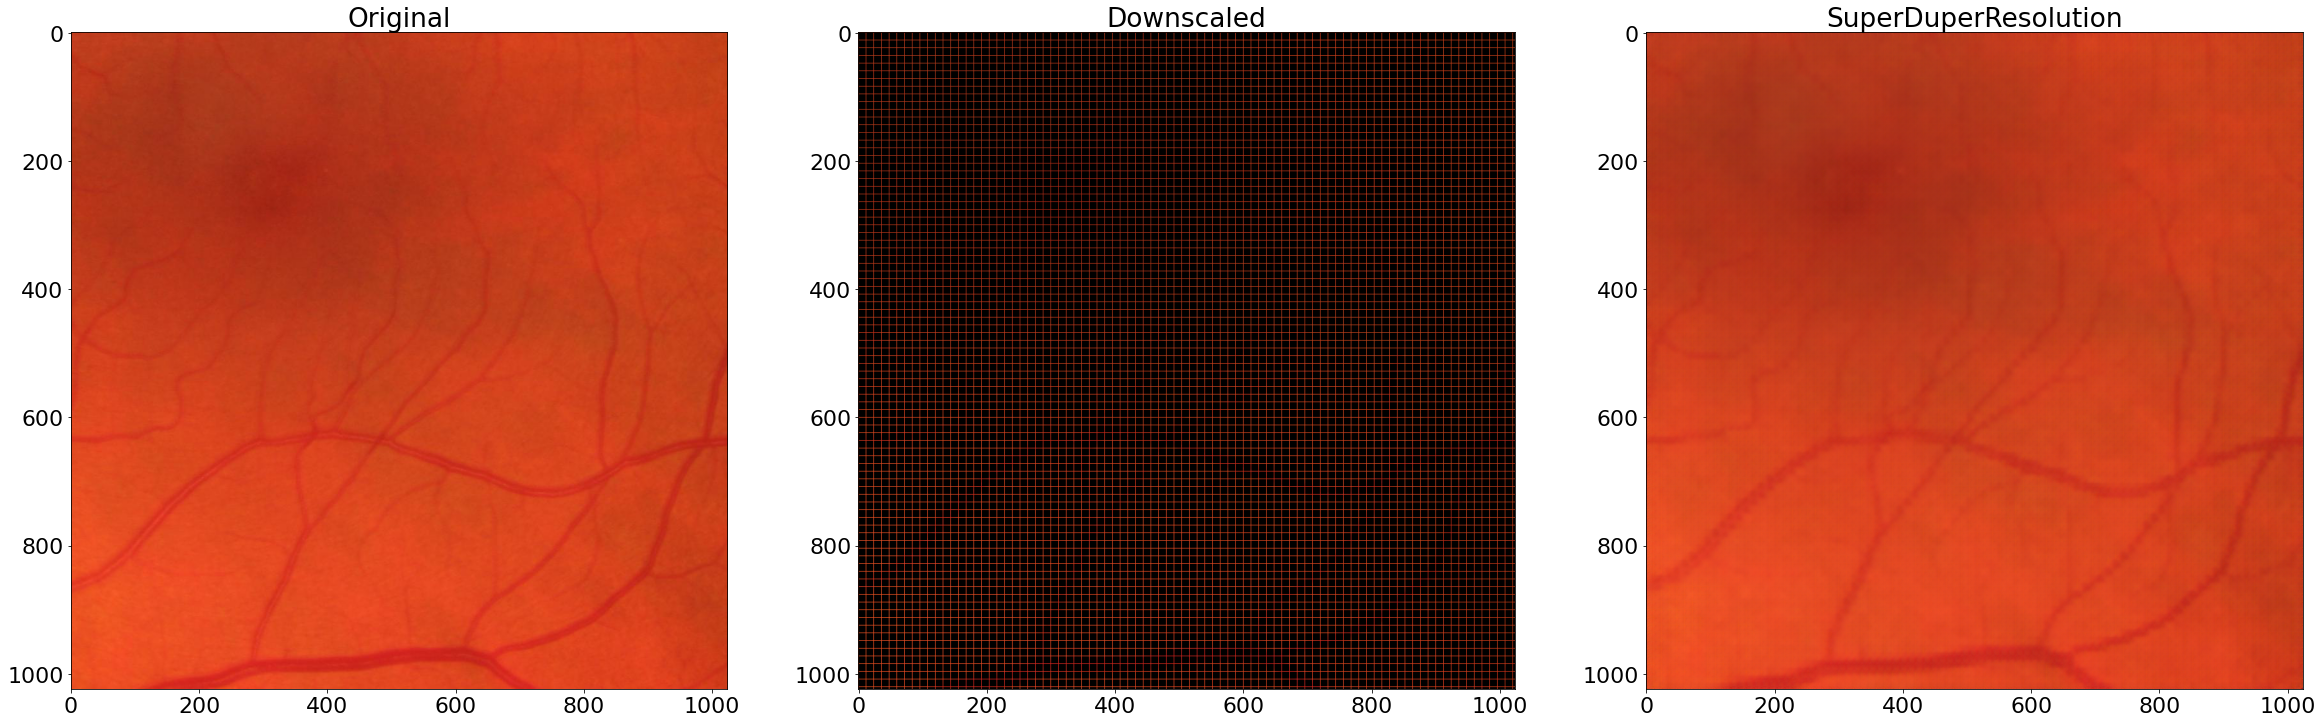

In [10]:
plt.rcParams.update({'font.size': 22})
fig, axes = plt.subplots(1, 3, figsize=(40, 20))

axes[0].imshow(gt_data[idx].to('cpu').detach().numpy().transpose(1,2,0))
axes[0].set_title('Original')
axes[1].imshow(ds_data[idx].to('cpu').detach().numpy().transpose(1,2,0))
axes[1].set_title('Downscaled')
axes[2].imshow(pred[0].to('cpu').detach().numpy().transpose(1,2,0))
axes[2].set_title('SuperDuperResolution')
plt.show()

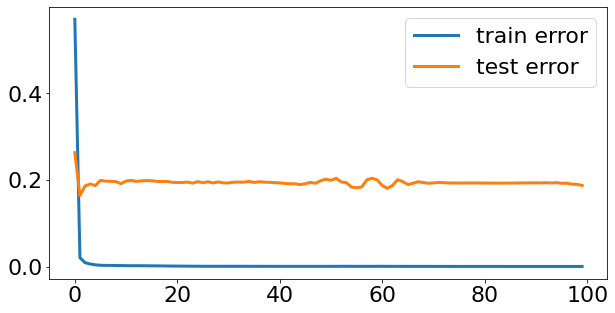

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(range(n_epochs), train_loss, linewidth=3, label='train error')
ax.plot(range(n_epochs), test_loss, linewidth=3, label='test error')
ax.legend()
plt.show()

Notes
- We could get more data
- One idea to try GANs
- MSE and PSNR can be used to evaluate the images
